<a href="https://colab.research.google.com/github/jjang6251/intelligentsoftware/blob/main/(IS)4%EC%A3%BC%EC%B0%A8.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

loss is 0.25638657808303833
####### TEST 결과 이미지 출력 #######
torch.Size([100, 28, 28])


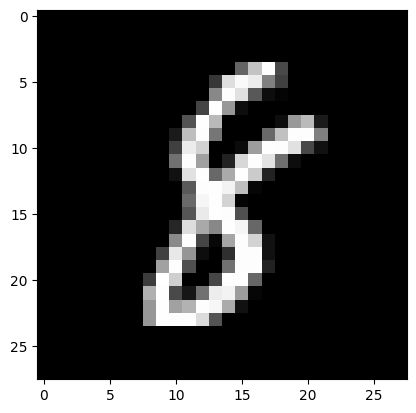

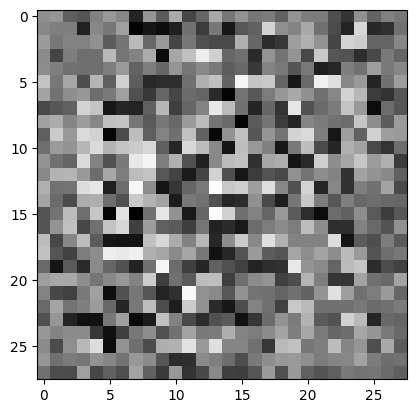

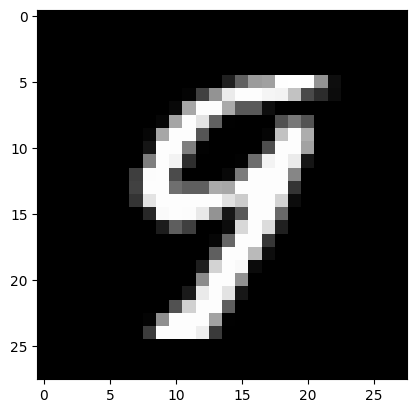

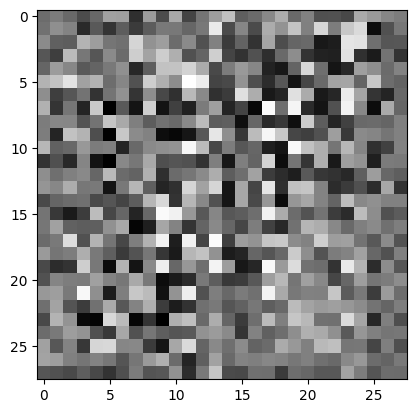

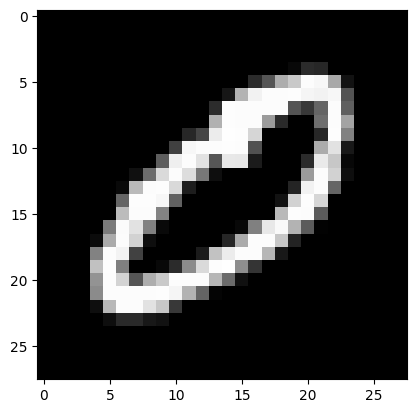

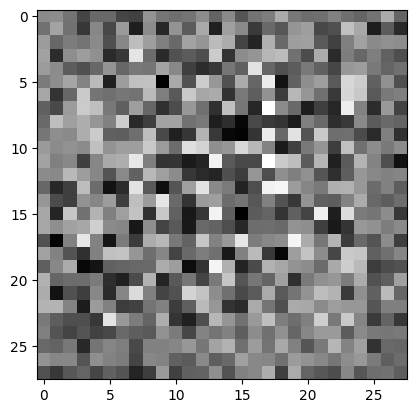

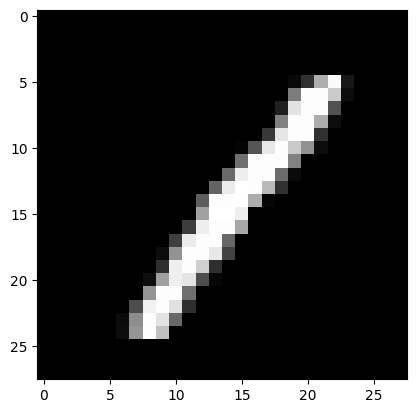

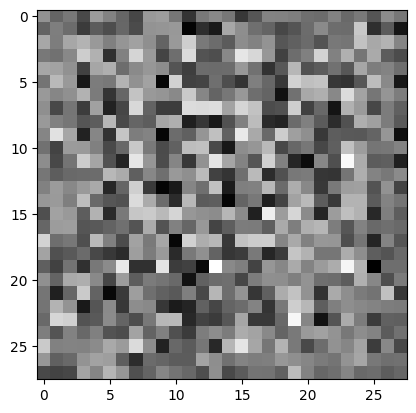

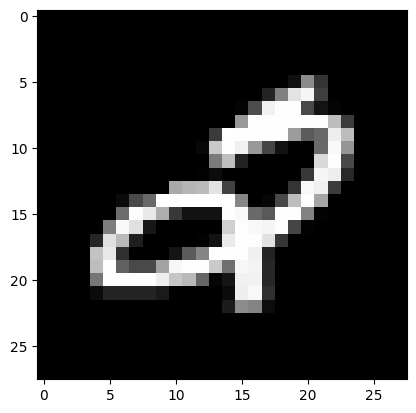

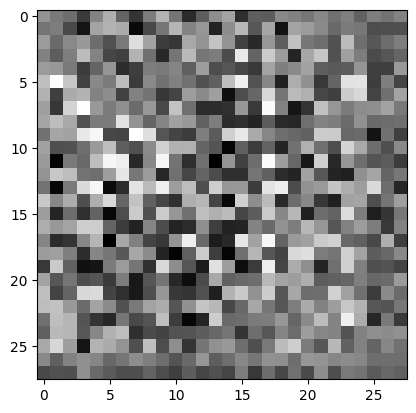

Epoch [1/10], Step [100/600], Loss: 0.0769
Epoch [1/10], Step [200/600], Loss: 0.0541
Epoch [1/10], Step [300/600], Loss: 0.0409
Epoch [1/10], Step [400/600], Loss: 0.0279
Epoch [1/10], Step [500/600], Loss: 0.0229
Epoch [1/10], Step [600/600], Loss: 0.0177
Epoch [2/10], Step [100/600], Loss: 0.0136
Epoch [2/10], Step [200/600], Loss: 0.0121
Epoch [2/10], Step [300/600], Loss: 0.0099
Epoch [2/10], Step [400/600], Loss: 0.0076
Epoch [2/10], Step [500/600], Loss: 0.0071
Epoch [2/10], Step [600/600], Loss: 0.0069
Epoch [3/10], Step [100/600], Loss: 0.0049
Epoch [3/10], Step [200/600], Loss: 0.0047
Epoch [3/10], Step [300/600], Loss: 0.0046
Epoch [3/10], Step [400/600], Loss: 0.0037
Epoch [3/10], Step [500/600], Loss: 0.0036
Epoch [3/10], Step [600/600], Loss: 0.0031
Epoch [4/10], Step [100/600], Loss: 0.0027
Epoch [4/10], Step [200/600], Loss: 0.0028
Epoch [4/10], Step [300/600], Loss: 0.0026
Epoch [4/10], Step [400/600], Loss: 0.0024
Epoch [4/10], Step [500/600], Loss: 0.0027
Epoch [4/10

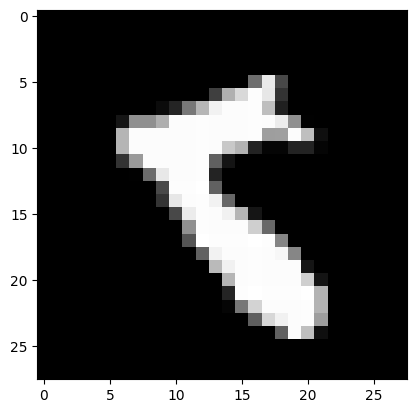

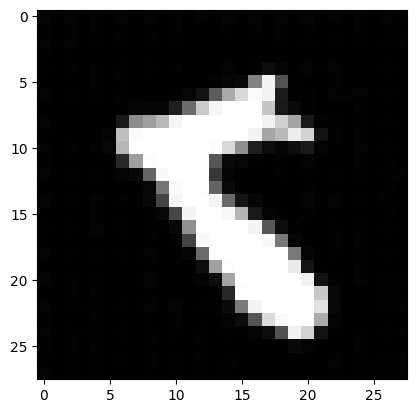

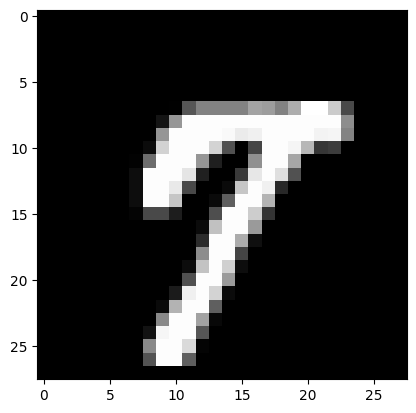

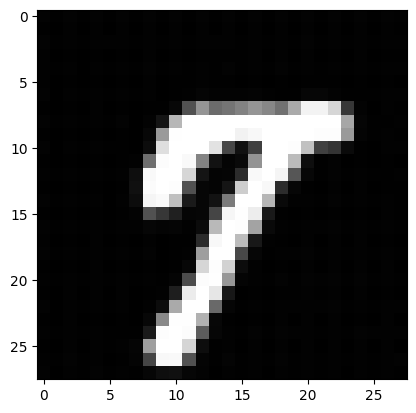

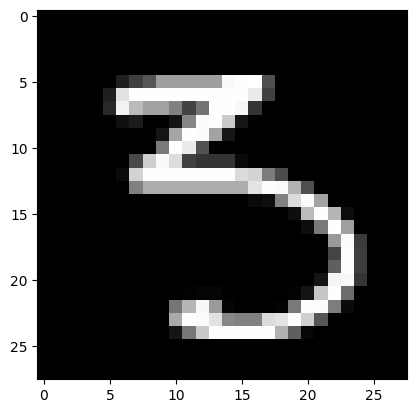

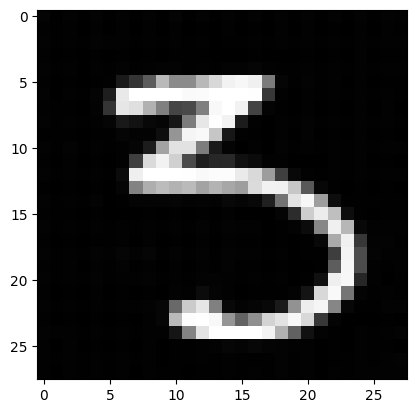

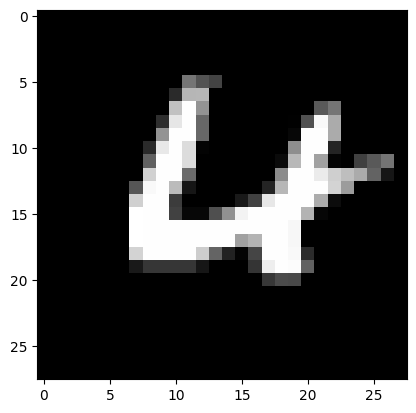

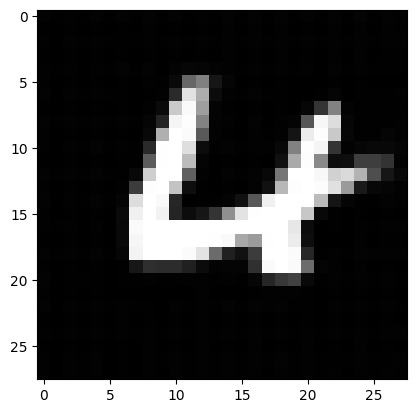

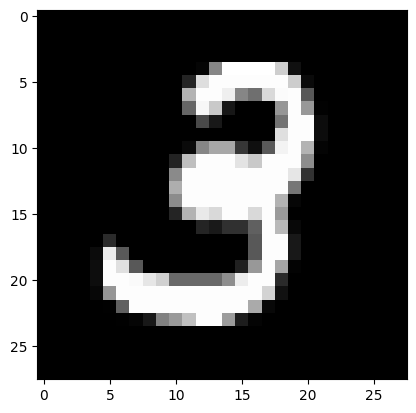

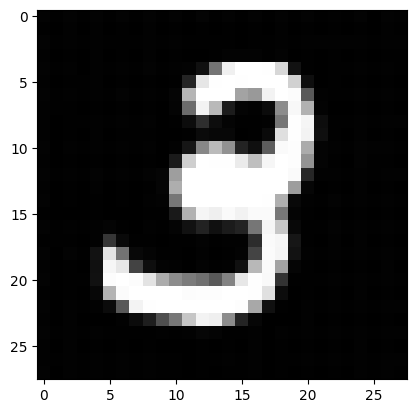

In [3]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.datasets as dset
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import itertools
%matplotlib inline

class Encoder(nn.Module):
    def __init__(self):
        super(Encoder, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(1, 16, 3, padding=1),  # 16 x 28 x 28
            nn.ReLU(),
            nn.BatchNorm2d(16),
            nn.Conv2d(16, 32, 3, padding=1),  # 32 x 28 x 28
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.Conv2d(32, 64, 3, padding=1),  # 64 x 28 x 28
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.MaxPool2d(2, 2)  # 64 x 14 x 14
        )

        self.layer2 = nn.Sequential(
            nn.Conv2d(64, 128, 3, padding=1),  # 128 x 14 x 14
            nn.ReLU(),
            nn.BatchNorm2d(128),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(128, 256, 3, padding=1),  # 256 x 7 x 7
            nn.ReLU()
        )

    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        batch_size = x.size(0)
        out = out.view(batch_size, -1)
        return out

class Decoder(nn.Module):
    def __init__(self):
        super(Decoder, self).__init__()
        self.layer1 = nn.Sequential(
            nn.ConvTranspose2d(256, 128, 3, 2, 1, 1),  # 128 x 14 x 14
            nn.ReLU(),
            nn.BatchNorm2d(128),
            nn.ConvTranspose2d(128, 64, 3, 1, 1),  # 64 x 14 x 14
            nn.ReLU(),
            nn.BatchNorm2d(64)
        )
        self.layer2 = nn.Sequential(
            nn.ConvTranspose2d(64, 16, 3, 1, 1),  # 16 x 14 x 14
            nn.ReLU(),
            nn.BatchNorm2d(16),
            nn.ConvTranspose2d(16, 1, 3, 2, 1, 1),  # 1 x 28 x 28
            nn.Sigmoid()
        )

    def forward(self, x):
        batch_size = x.size(0)
        out = x.view(batch_size, 256, 7, 7)
        out = self.layer1(out)
        out = self.layer2(out)
        return out

# 데이터 로딩 & 데이터 로더
mnist_train = dset.MNIST("./data/MNIST", train=True,
                         transform=transforms.ToTensor(), download=True)
mnist_test = dset.MNIST("./data/MNIST", train=False,
                        transform=transforms.ToTensor(), download=True)

batch_size = 100
train_loader = DataLoader(mnist_train, batch_size=batch_size, shuffle=True, num_workers=0, drop_last=True)
test_loader = DataLoader(mnist_test, batch_size=batch_size, shuffle=False, num_workers=0, drop_last=True)

# 초기 설정
num_epoch = 10
learning_rate = 0.0002
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

encoder = Encoder().to(device)
decoder = Decoder().to(device)

parameters = itertools.chain(encoder.parameters(), decoder.parameters())
loss_func = nn.MSELoss()
optimizer = torch.optim.Adam(parameters, lr=learning_rate)

# 훈련 전에 test해보기
for i in range(1):
  for j,[image, label] in enumerate(test_loader):
    image = image.to(device)
    z = encoder(image)
    output = decoder(z)
    loss = loss_func(output,image)
# if j % 10 == 0:
# print(loss)
  print("loss is", loss.cpu().item())

#Test 결과 출력
out_img = torch.squeeze(output.cpu().data)
print("####### TEST 결과 이미지 출력 #######")
print(out_img.size())
for i in range(5):
  plt.imshow(torch.squeeze(image[i].cpu()).data.numpy(),cmap='gray')
  plt.show()
  plt.imshow(out_img[i].numpy(),cmap='gray')
  plt.show()



#훈련
for i in range(num_epoch):
  for j,[image, label] in enumerate(train_loader):
    optimizer.zero_grad()
    image = image.to(device)
    z = encoder(image)
    output = decoder(z)
    loss = loss_func(output, image)
    loss.backward()
    optimizer.step()

    #학습진행률 확인
    if (j + 1) % 100 == 0:
            print(f"Epoch [{i+1}/{num_epoch}], Step [{j+1}/{len(train_loader)}], Loss: {loss.item():.4f}")
print("loss is", loss.cpu().item())

#훈련 결과 출력
out_img = torch.squeeze(output.cpu().data)
print("####### 훈련 결과 이미지 출력 #######")
print(out_img.size())
for i in range(5):
  plt.imshow(torch.squeeze(image[i].cpu()).data.numpy(),cmap='gray')
  plt.show()
  plt.imshow(out_img[i].numpy(),cmap='gray')
  plt.show()